In [1]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import string
from datetime import datetime
from twitter_source.database import DatabaseUtil
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from sklearn import preprocessing
%matplotlib inline

* data preparing

In [2]:
# connect to the sqlite3 db file, utilizing the customized module
db = DatabaseUtil()
engine = db.get_engine()
conn = engine.connect()

In [3]:
df = pd.read_sql('select * from tweets', conn)

In [4]:
# twitter text processing and cleaning function
def process_words(raw, remove_punc=False, stem=False):
    link_pattern = [
        r'(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*\s',
        r'\s+(http|https)://[a-zA-Z0-9\./]*$',
    ]
    clean = raw.lower().strip()
    for ptn in link_pattern:
        clean = re.sub(ptn, '', clean)
    if remove_punc:
        nopunc = [c for c in clean if c not in string.punctuation]
        raw = ''.join(nopunc)

    stopwords_list = []
    stopwords_list_en = set(stopwords.words('english'))
    stopwords_list_fr = set(stopwords.words('french'))
    stopwords_list.extend(stopwords_list_en)
    stopwords_list.extend(stopwords_list_fr)
   
    nostop = [w for w in raw.split() if w.lower() not in stopwords_list]
    if stem:
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(t) for t in nostop])
    else:
        return ' '.join(nostop)

In [5]:
df['tweet_clean'] = df['tweet'].apply(lambda t: process_words(t, remove_punc=True))

In [6]:
# transform tweet timestamp from string format to datetime
df['date'] = df['timestamp'].apply(lambda t: re.findall('\d\d\d\d-\d\d-\d\d',t)[0])
df['date'] = df['date'].apply(lambda s: datetime.strptime(s,'%Y-%m-%d'))

* Exploratory Analysis

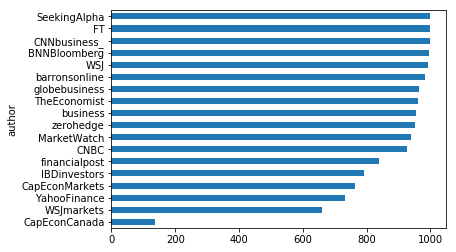

In [7]:
# count the number of tweets collected from each news outlet
tweetcount = df.groupby('author')['tweet'].count().sort_values().plot(kind='barh')

In [8]:
# initiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [9]:
df['sentiment'] = df['tweet'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

In [10]:
focus = df[['author','date','tweet','sentiment']]

In [11]:
# filter recent tweets
filter_time = focus['date'] >= datetime(2018,1,1)
recent = focus[filter_time].set_index('date')

In [12]:
# group data by month
grouper = recent.groupby(pd.Grouper(freq='M'))
groupby_month = grouper.mean().reset_index()

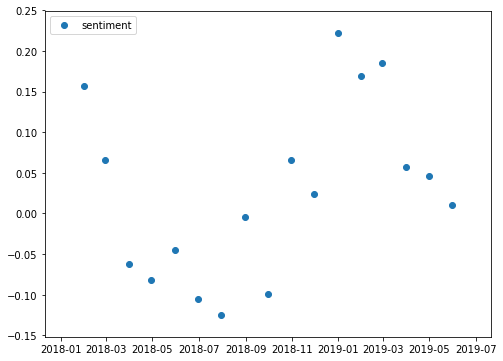

In [13]:
# show sentiment fluctuation of each month
plt.figure(figsize=(8,6))
plt.scatter(x=groupby_month['date'],y=groupby_month['sentiment'])
plt.legend(loc='upper left')
plt.show()

In [14]:
# group data by tweet account
groupby_author = recent.groupby('author').mean().reset_index().sort_values('sentiment')

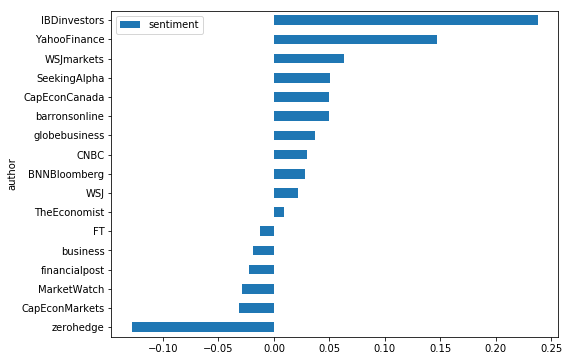

In [15]:
# optimitic vs pessimistic news agencies
groupby_author.plot(x='author',kind='barh', figsize = (8,6))